In [1]:
# import visdom
# import numpy as np
# vis = visdom.Visdom(server='http://localhost',port='8097')

In [1]:
from pyntcloud import PyntCloud
from pyntcloud.io import bin as io_bin
import numpy as np
import pandas as pd
import os

from pythreejs import *
import numpy as np
from IPython.display import display
from ipywidgets import HTML, Text, Output, VBox
from traitlets import link, dlink

In [2]:
import cv2

In [3]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib notebook
import numpy as np

In [4]:
flags = [i for i in dir(cv2) if i.startswith('COLOR_')]

<IPython.core.display.Javascript object>


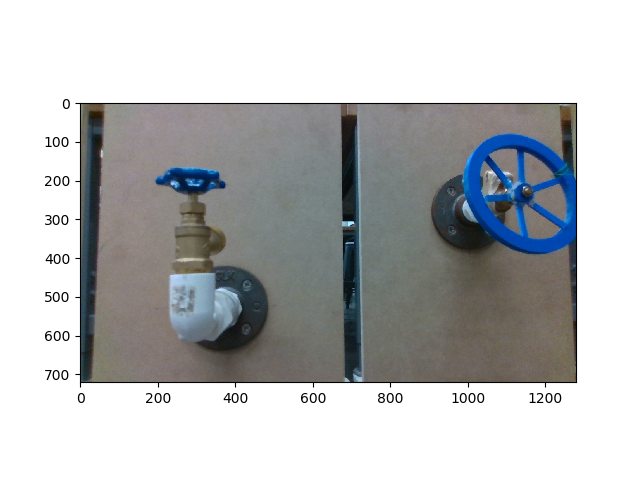

In [5]:
image = cv2.imread('./images/frame0150.jpg') # OpenCV by default reads the image as BGR
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

<IPython.core.display.Javascript object>


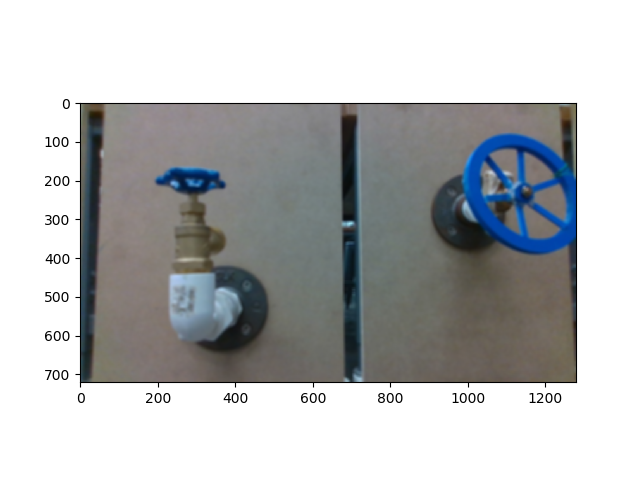

In [6]:
image_blurred = cv2.GaussianBlur(image, (9,9), 80)
plt.figure()
plt.imshow(image_blurred)
image = image_blurred

#### HSV is a good choice of color space for segmenting by color
Lets see the color distribution of its pixels

In [67]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors

In [68]:
r,g,b = cv2.split(image)
# fig = plt.figure()
# ax = fig.add_subplot(1,1,1, projection='3d')

pixels_channels = image.reshape((image.shape[0]*image.shape[1], 3))
normalizer = colors.Normalize(vmin=-1.,vmax=1.)
normalizer.autoscale(pixels_channels)
pixels_colors =  normalizer(pixels_channels).tolist()

# ax.scatter(r.flatten(), g.flatten(), b.flatten(), facecolors=pixels_colors, marker=".")
# ax.set_xlabel("Red")
# ax.set_ylabel("Green")
# ax.set_zlabel("Blue")
# plt.show()

In [69]:
colorlist = np.array(np.array(pixels_colors)*255, np.int)
pts = np.concatenate([[r.flatten()], [g.flatten()], [b.flatten()]]).transpose(1,0)

In [70]:
sample_ind = [np.random.randint(0, len(pts)) for i in range(8000)]
colorlist = colorlist[sample_ind]
pts = pts[sample_ind]

<IPython.core.display.Javascript object>


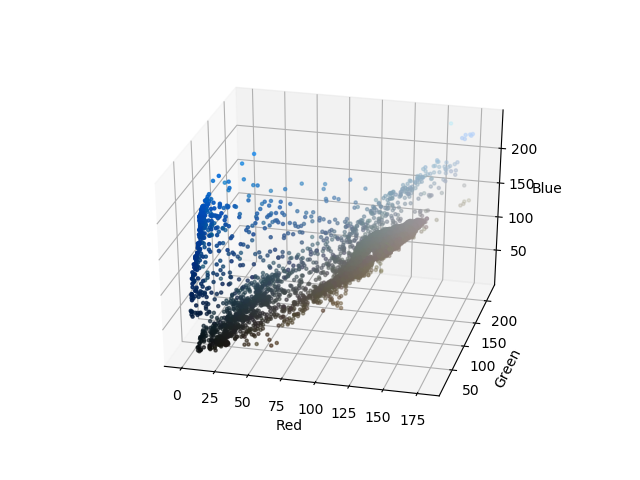

In [71]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection='3d')

ax.scatter(pts[:, 0], pts[:, 1], pts[:, 2], facecolors=(colorlist/255).tolist(), marker=".")
ax.set_xlabel("Red")
ax.set_ylabel("Green")
ax.set_zlabel("Blue")
plt.show()

In [72]:
hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

h,s,v = cv2.split(hsv_image)
# fig = plt.figure()
# ax = fig.add_subplot(1,1,1, projection='3d')

# ax.scatter(h.flatten(), s.flatten(), v.flatten(), facecolors=pixels_colors, marker=".")
# ax.set_xlabel("H")
# ax.set_ylabel("S")
# ax.set_zlabel("V")
# plt.show()

<IPython.core.display.Javascript object>


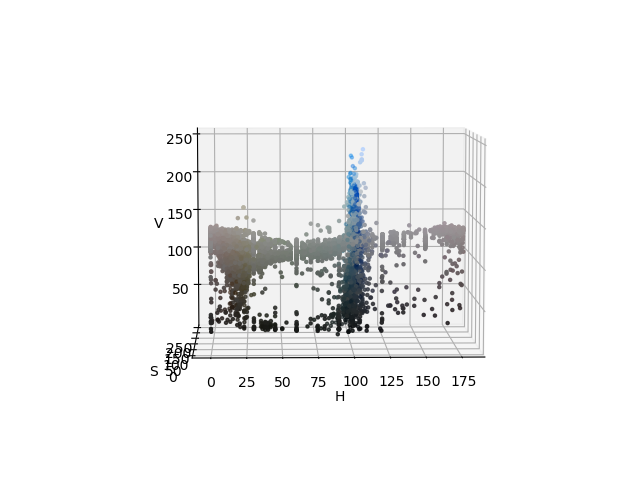

In [73]:
colorlist = np.array(np.array(pixels_colors)*255, np.int)
pts = np.concatenate([[h.flatten()], [s.flatten()], [v.flatten()]]).transpose(1,0)

sample_ind = [np.random.randint(0, len(pts)) for i in range(9000)]
colorlist = colorlist[sample_ind]
pts = pts[sample_ind]

fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection='3d')

ax.scatter(pts[:, 0], pts[:, 1], pts[:, 2], facecolors=(colorlist/255).tolist(), marker=".")
ax.set_xlabel("H")
ax.set_ylabel("S")
ax.set_zlabel("V")
plt.show()

<IPython.core.display.Javascript object>


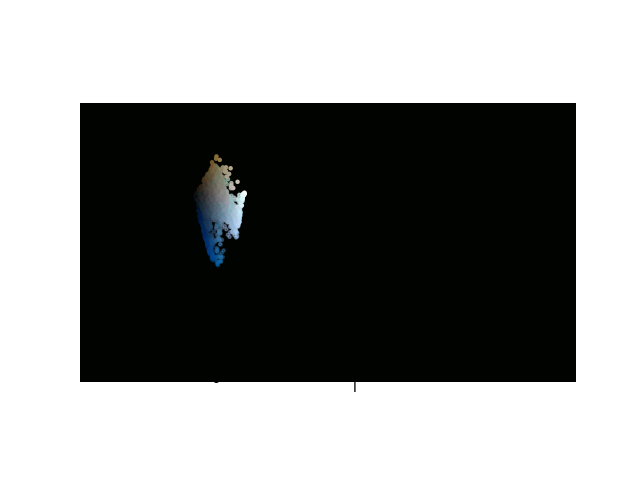

In [58]:
hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)

l,u,v = cv2.split(hsv_image)

colorlist = np.array(np.array(pixels_colors)*255, np.int)
pts = np.concatenate([[l.flatten()], [u.flatten()], [v.flatten()]]).transpose(1,0)

sample_ind = [np.random.randint(0, len(pts)) for i in range(15000)]
colorlist = colorlist[sample_ind]
pts = pts[sample_ind]

fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection='3d')

ax.scatter(pts[:, 0], pts[:, 1], pts[:, 2], facecolors=(colorlist/255).tolist(), marker=".")
ax.set_xlabel("l")
ax.set_ylabel("u")
ax.set_zlabel("V")
plt.show()

#### Nemo’s oranges are much more localized and visually separable.
value of the oranges do vary, but they are mostly located within a small range along the hue axis.
Choose a range of colors:

#### Using  cv2.inRange() to try to threshold the colors:

<IPython.core.display.Javascript object>


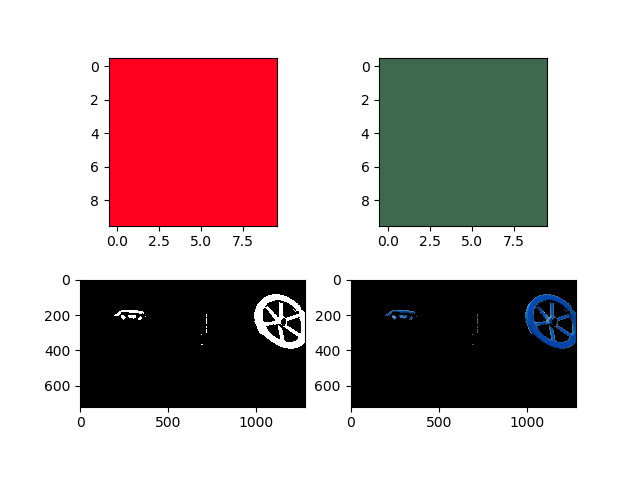

In [146]:
# light_white = (206*255/360, 0.768*255, 0.745*255)
# dark_white = (211*255/360, 50*255, 5*255)

# light_white = (70, 140, 140) #(100, 200, 200) # (150, 200, 200)  # large one 
# dark_white = (150, 255, 255)

# light_white = (20, 110, 110) #(100, 200, 200) # (150, 200, 200) # edges
# dark_white = (250, 250, 250)

light_white = (100, 100, 105) #(100, 200, 200) # (150, 200, 200) # increasing sv will reduce blue colors, increasinf h will reduce blue
dark_white = (250, 255, 255) # reducing sv will make edges

lo_square = np.full((10, 10, 3), light_white, dtype=np.uint8) / 255.0
do_square = np.full((10, 10, 3), dark_white, dtype=np.uint8) / 255.0
fig2 = plt.figure()
plt.subplot(2, 2, 1)
plt.imshow(hsv_to_rgb(do_square))
plt.subplot(2, 2, 2)
plt.imshow(hsv_to_rgb(lo_square))

mask_white= cv2.inRange(hsv_image, light_white, dark_white) # O means not in range 1 means in range
masked_image = cv2.bitwise_and(image, image, mask=mask_white)
plt.subplot(2,2, 3)
plt.imshow(mask_white, cmap='gray')
plt.subplot(2,2,4)
plt.imshow(masked_image)

In [9]:
Z = image
Z = np.float32(Z)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 3
ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((image.shape))

<IPython.core.display.Javascript object>


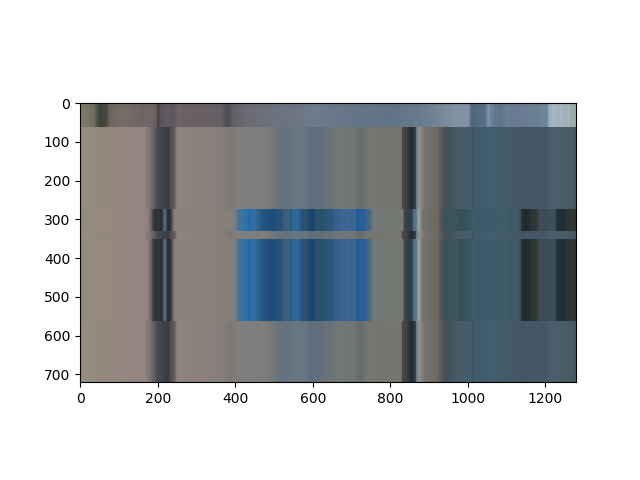

In [10]:
plt.figure()
plt.imshow(res2)

In [135]:
final_mask = mask_orange + mask_white

final_image = cv2.bitwise_and(image, image, mask=final_mask)
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(final_mask, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(final_image)
plt.show()

NameError: name 'mask_orange' is not defined

<IPython.core.display.Javascript object>


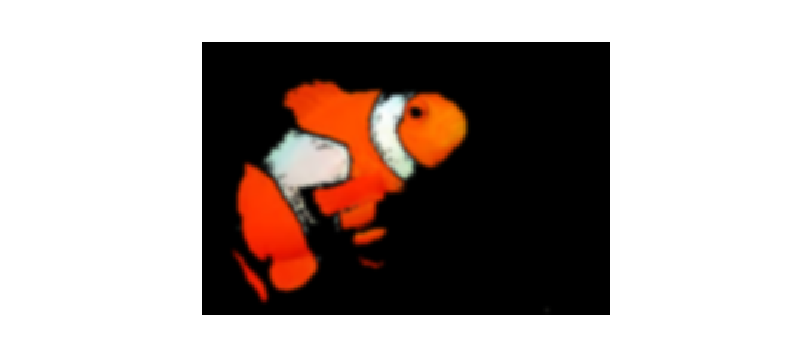

In [56]:
blurred = cv2.GaussianBlur(final_image, (7,7), 0)
plt.figure()
plt.imshow(blurred)

<IPython.core.display.Javascript object>


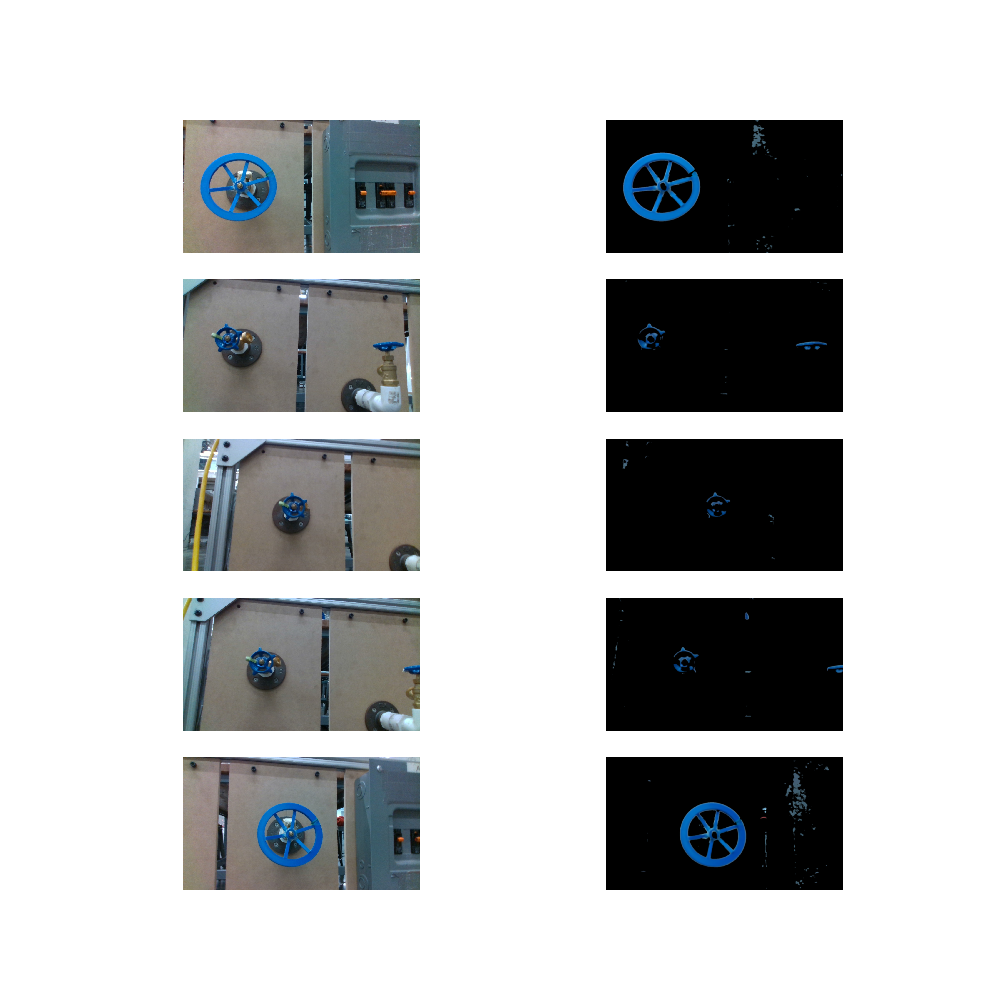

In [7]:
import os
import cv2
import glob
import numpy as np
from matplotlib.colors import hsv_to_rgb
import matplotlib.pyplot as plt

def Masking(image, color_ranges):
    image = cv2.GaussianBlur(image, (9,9), 80)
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    final_mask = np.full(image.shape[:-1],0,dtype=np.uint8)
    for each_range in color_ranges:
        final_mask += cv2.inRange(hsv_image, each_range[0], each_range[1])
    final_image = cv2.bitwise_and(image, image, mask=final_mask)
    blurred_image = cv2.GaussianBlur(final_image, (7,7), 0)
    return blurred_image
    
# light_white = (920, 240, 100)
# dark_white = (910, 120, 250)
light_white = (100, 100, 105)
dark_white = (250, 255, 255)

color_ranges= np.array([[light_white, dark_white]])

# what happened? there?ok
path = os.path.join("./images/*")
file_list = glob.glob(path)
file_list = np.array(file_list)[np.arange(0,200,20)]
file_list = file_list[:5]
file_list_len = len(file_list)
fig = plt.figure(figsize=(10,10))
images = list()
result_images = list()
plots = 1
for file in file_list:
    image = cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB)
    result_image = Masking(image, color_ranges)
    plt.subplot(file_list_len, 2, plots)
    plt.axis('off')
    plt.imshow(image)
    plots+=1
    plt.subplot(file_list_len, 2, plots)
    plt.axis('off')
    plt.imshow(result_image)
    plots+=1
    images.append(image)
    result_images.append(result_image)
    
plt.show()